In [1]:
import pathlib
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import holidays
import ipympl
import nodejs
import datetime as dt

#### Data Paths
All data paths are collected here for easy adjustments.

In [2]:
data_path_hc = r"data/HouseConnection_PxC_2018_2019.csv"
data_path_weather = r"data/WeatherHistory_PxC_2018_2019_NewSolarCalc.csv"
data_path_result = r"data/HouseConnection_WeatherForecast_PxC_2018_2019.csv"

## Prepare Data - House Connection Historic Data

In [4]:
# Load in the historic house connection data for 2018 - 2019.
houseconnection_data = pd.read_csv(data_path_hc)
# Data in the table was actually kWh in 15 minute resolution.
# We need to convert this to kW (145 minutes => hour).
houseconnection_data.kw = houseconnection_data.kw * 4

# Correct the date time format of the timestamp.
houseconnection_data.ts = pd.to_datetime(houseconnection_data.ts, yearfirst=True)
houseconnection_data.ts = pd.to_datetime(houseconnection_data.ts.dt.strftime("%Y-%m-%d %H:%M:%S"))

# Inspect the result.
print('Samples:', len(houseconnection_data))
print('Nan: ', houseconnection_data.isna().sum())
houseconnection_data.head()

Samples: 63201
Nan:  ts    0
kw    1
dtype: int64


,ts,kw
0,2017-12-31 23:00:00,NaN
1,2017-12-31 23:15:00,84.0
2,2017-12-31 23:30:00,80.0
3,2017-12-31 23:45:00,84.0
4,2018-01-01 00:00:00,84.0


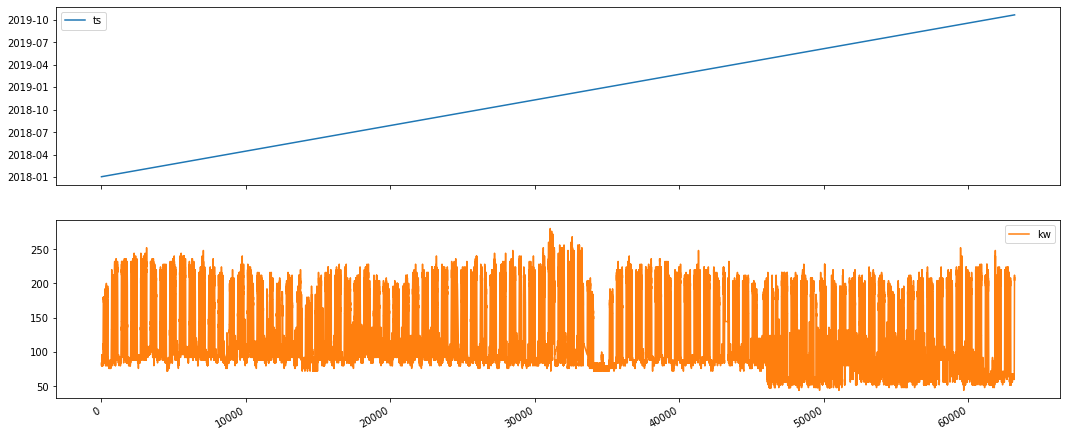

In [5]:
houseconnection_data.plot(subplots=True, figsize=(18, 8))
plt.show()

## Prepare Data - Weather Measurements History

#### Load Weather Measurements Data
For the years 2018 - 2019 we do not have weather forecast data from the DWD. This is due to the fact that this data needs to be recorded when it is published. Such records where started in 2020. To match the historic measurements data with the forecast data used for 2020, some values where caulcualted. For this calcualtion two meathods where developed. The data present here uses the newer calculation proceedure.

In [6]:
weather_data = pd.read_csv(data_path_weather)
# We do not need the wind columns as they are not present in 2020 data.
weather_data = weather_data.drop(columns=["wind_u", "wind_v", "kw"])

# Correct the date time format of the timestamp.
weather_data.ts = pd.to_datetime(weather_data.ts, yearfirst=True)
weather_data.head()

,ts,solar_global,solar_direct,solar_diff_down,pressure,temp,rel_humidity
0,2018-01-01 00:00:00,0.0,0.0,0.0,967.8,8.50,82.5
1,2018-01-01 00:15:00,0.0,0.0,0.0,967.8,8.60,81.2
2,2018-01-01 00:30:00,0.0,0.0,0.0,967.9,8.60,81.1
3,2018-01-01 00:45:00,0.0,0.0,0.0,968.0,8.55,80.4
4,2018-01-01 01:00:00,0.0,0.0,0.0,968.1,8.30,79.2


#### Merge Weather and House Connection Data

In [7]:
# Merge the weather dataframe with the house connection dataframe using the timestamp.
data_merged = pd.merge_asof(houseconnection_data.copy(), weather_data, on='ts')
print('Samples:', len(data_merged))
print('Nan: ', data_merged.isna().sum())
data_merged.head()

Samples: 63201
Nan:  ts                    0
kw                    1
solar_global       4441
solar_direct       4441
solar_diff_down    4441
pressure            239
temp                239
rel_humidity        239
dtype: int64


,ts,kw,solar_global,solar_direct,solar_diff_down,pressure,temp,rel_humidity
0,2017-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-12-31 23:15:00,84.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-12-31 23:30:00,80.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-12-31 23:45:00,84.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 00:00:00,84.0,0.0,0.0,0.0,967.8,8.5,82.5


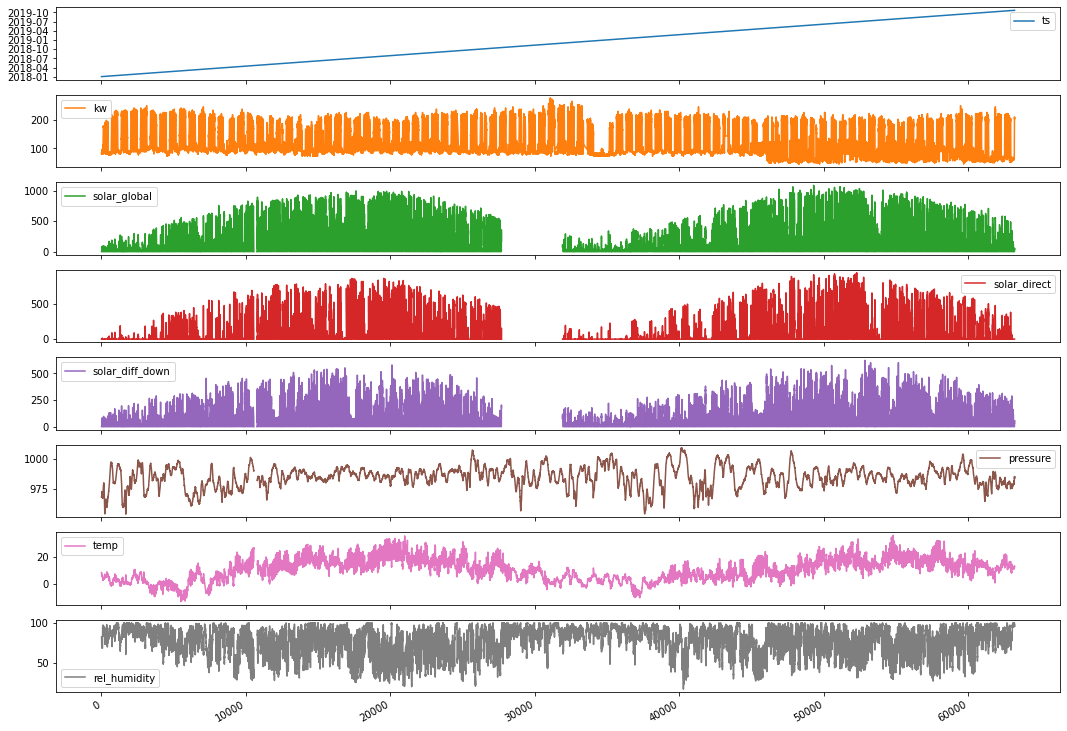

In [8]:
# Plot the data to inspect where all the nans are found.
# Seems that there is just one big gap in between the years.
data_merged.plot(subplots=True, figsize=(18, 14))
plt.show()

#### Augment Data
We separate the timestamp into multiple columns and add a field indicating holidays. This augmentation makes sense as the energy consumed by an office building largely depends an work day cycles. Having days and hours in individual columns leads to better results in the training process. 

In [9]:
# Create multiple columns for timestamps.
data_merged['year'] = pd.DatetimeIndex(data_merged.ts).year
data_merged['month'] = pd.DatetimeIndex(data_merged.ts).month
data_merged['day'] = pd.DatetimeIndex(data_merged.ts).day
data_merged['hour'] = pd.DatetimeIndex(data_merged.ts).hour
data_merged['minute'] = pd.DatetimeIndex(data_merged.ts).minute
data_merged['weekday'] = data_merged.ts.dt.dayofweek

# The year is not significant.
data_merged = data_merged.drop(columns = ['year'])

In [10]:
# We also want to add a field identifying german holidays (Niedersachsen).
holidays_de_ni = holidays.Germany(prov='NI')
data_merged['holiday'] = data_merged.ts.apply(lambda x: x in holidays_de_ni)
data_merged["holiday"] = data_merged["holiday"].astype(int)

# Finally we use the timestamp as the index again.
data_merged = data_merged.set_index('ts', drop=True)
data_merged.head()

,kw,solar_global,solar_direct,solar_diff_down,pressure,temp,rel_humidity,month,day,hour,minute,weekday,holiday
ts,,,,,,,,,,,,,
2017-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,31,23,0,6,0
2017-12-31 23:15:00,84.0,NaN,NaN,NaN,NaN,NaN,NaN,12,31,23,15,6,0
2017-12-31 23:30:00,80.0,NaN,NaN,NaN,NaN,NaN,NaN,12,31,23,30,6,0
2017-12-31 23:45:00,84.0,NaN,NaN,NaN,NaN,NaN,NaN,12,31,23,45,6,0
2018-01-01 00:00:00,84.0,0.0,0.0,0.0,967.8,8.5,82.5,1,1,0,0,0,1


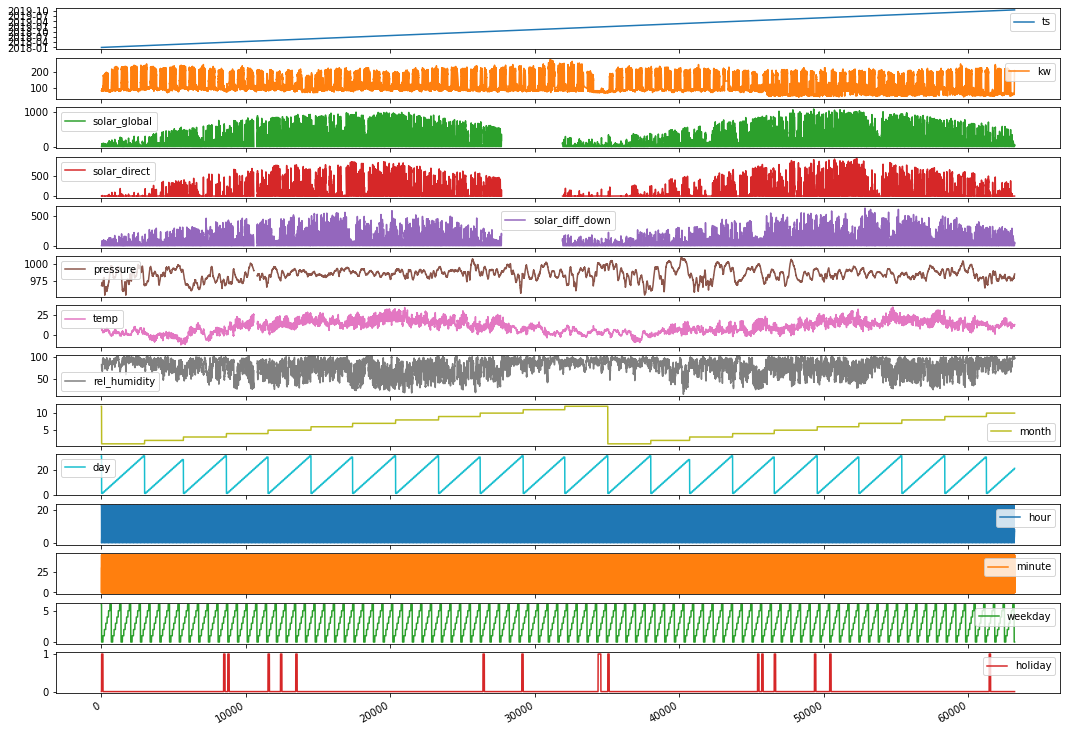

In [11]:
data_merged.reset_index().plot(subplots=True, figsize=(18, 14))
plt.show()

#### Data Consistency

In [12]:
# Drop the nan values. This needs to be checked as it might cause issues with sequence prdictions.
data_merged = data_merged.dropna()
data_merged.isna().sum()

kw                 0
solar_global       0
solar_direct       0
solar_diff_down    0
pressure           0
temp               0
rel_humidity       0
month              0
day                0
hour               0
minute             0
weekday            0
holiday            0
dtype: int64

#### Inspect the Result and Save Data for later Reuse

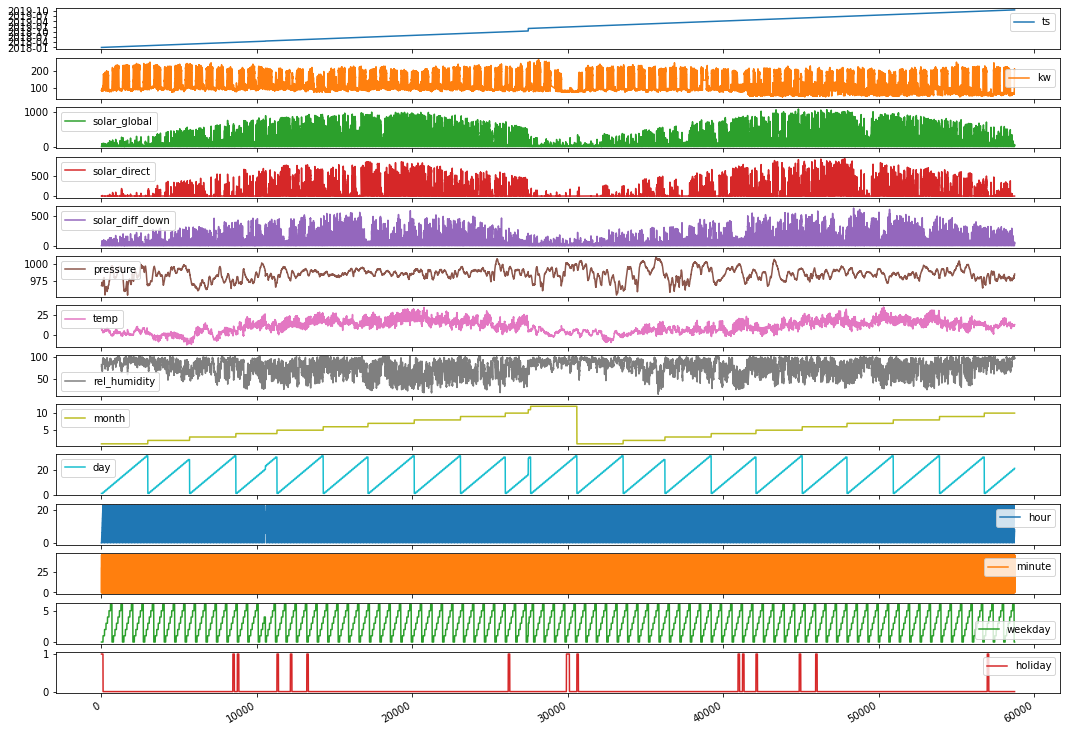

In [13]:
data_merged.reset_index().plot(subplots=True, figsize=(18, 14))
plt.show()

In [14]:
data_merged.tail()

,kw,solar_global,solar_direct,solar_diff_down,pressure,temp,rel_humidity,month,day,hour,minute,weekday,holiday
ts,,,,,,,,,,,,,
2019-10-21 07:00:00,212.0,31.666667,0.0,31.666667,983.80,12.90,97.00,10,21,7,0,0,0
2019-10-21 07:15:00,204.0,28.333333,0.0,28.333333,984.25,13.25,95.25,10,21,7,15,0,0
2019-10-21 07:30:00,208.0,58.333333,0.0,58.333333,984.40,13.00,95.50,10,21,7,30,0,0
2019-10-21 07:45:00,208.0,35.833333,0.0,35.833333,984.95,13.00,96.30,10,21,7,45,0,0
2019-10-21 08:00:00,208.0,46.666667,0.0,46.666667,985.20,13.20,96.20,10,21,8,0,0,0


In [15]:
# Save final prepared data to file.
data_merged.to_csv(data_path_result)

In [16]:
# Load the file to check if everything is fine.
data_merged = pd.read_csv(data_path_result, index_col='ts', parse_dates=['ts'])
data_merged.head()

,kw,solar_global,solar_direct,solar_diff_down,pressure,temp,rel_humidity,month,day,hour,minute,weekday,holiday
ts,,,,,,,,,,,,,
2018-01-01 00:00:00,84.0,0.0,0.0,0.0,967.8,8.50,82.5,1,1,0,0,0,1
2018-01-01 00:15:00,80.0,0.0,0.0,0.0,967.8,8.60,81.2,1,1,0,15,0,1
2018-01-01 00:30:00,80.0,0.0,0.0,0.0,967.9,8.60,81.1,1,1,0,30,0,1
2018-01-01 00:45:00,84.0,0.0,0.0,0.0,968.0,8.55,80.4,1,1,0,45,0,1
2018-01-01 01:00:00,80.0,0.0,0.0,0.0,968.1,8.30,79.2,1,1,1,0,0,1


## Done